In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark

In [46]:
app_name = "FinalProject"
sc.stop()
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '10g'), ('spark.executor.cores', '4'), ('spark.cores.max', '24'), ('spark.driver.memory','10g')])
sc = pyspark.SparkContext(conf=conf)


In [47]:
spark = SparkSession(sc)

In [62]:
sc._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.executor.instances', '10000'),
 ('spark.eventLog.dir', 'hdfs://clickratepredcluster-m/user/spark/eventlog'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.driver.appUIAddress', 'http://10.138.0.2:4040'),
 ('spark.executor.cores', '4'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '36977'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.proxyBase', '/proxy/application_1543933162988_0006'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.driver.maxResultSize', '1920m'),
 ('spark.shuffle.service.enabled', 'true'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.memory', '10g'),
 ('spark.app.id', 'application_1543933162988_0007'),
 ('spark.yarn

In [81]:
ctrtrainRDD = sc.textFile('gs://arvindw261bucket/train.txt')

In [82]:
FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [83]:
# # Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
# trainRDD, heldOutRDD = ctrtrainRDD.randomSplit([0.8,0.2], seed = 1)
# print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

In [84]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    f = features + [label]
    return(f)

In [85]:
ctr_train_RDD_cached = ctrtrainRDD.map(parse)

In [42]:
# sample = np.array(ctr_train_RDD_cached.map(lambda x: np.append(x[0], [x[1]]))
#                                 .takeSample(False, 300000))
# sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

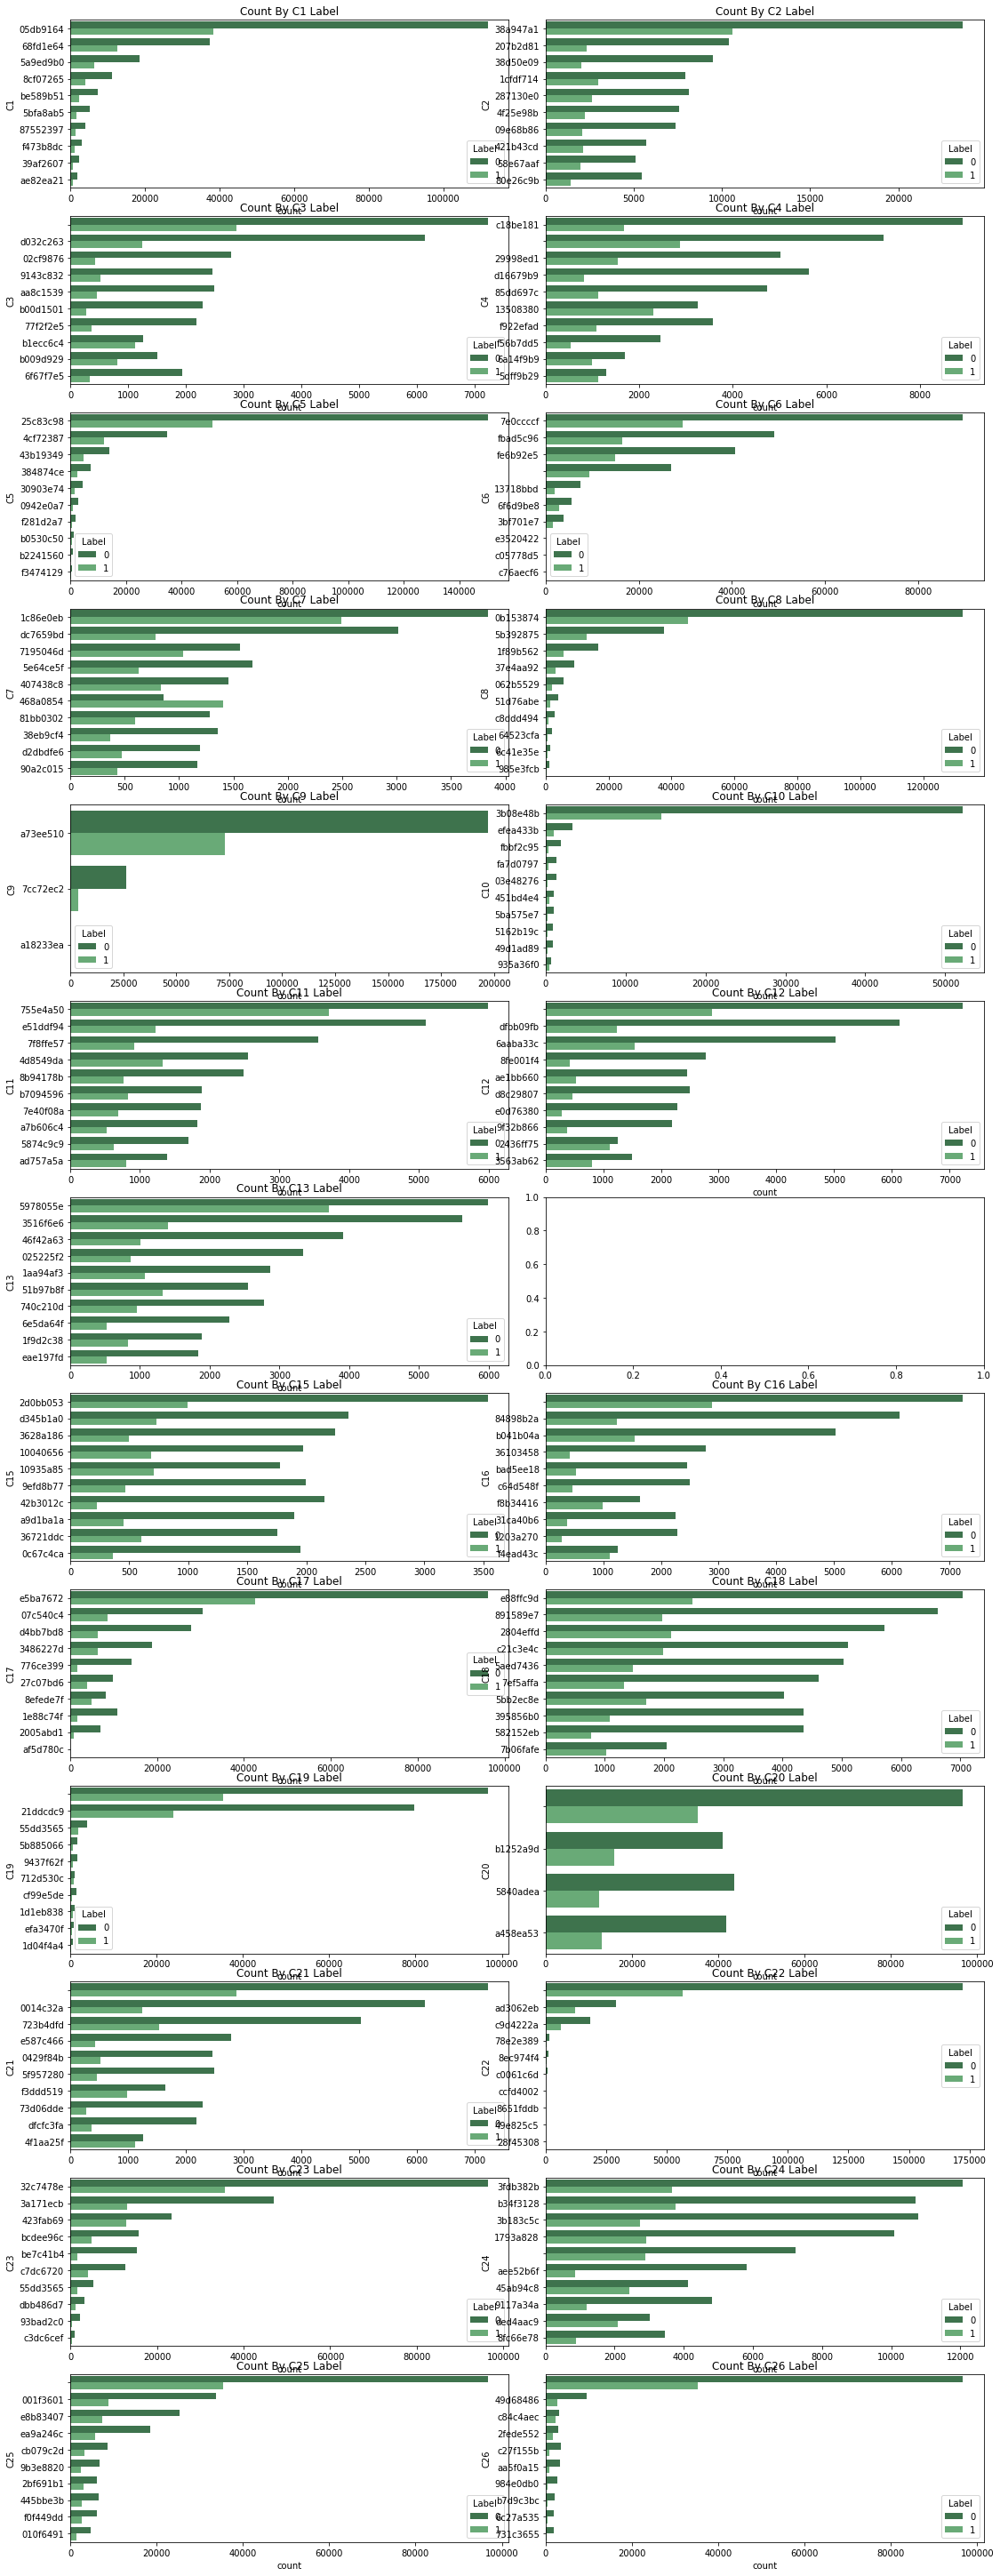

In [31]:
fig, ax = plt.subplots(13, 2,figsize=(15,40))
plt.tight_layout()
fno = 0
# axes are in a two-dimensional array, indexed by [row, col]
for i in range(13):
    for j in range(2):
        fno += 1

        col = "C" + str(fno)

        sns.countplot(y=col, hue="Label", data=sample_df, palette="Greens_d",
                  order=sample_df[col].value_counts().iloc[:10].index,ax=ax[i,j]).set_title('Count By C'+str(fno)+' Label')

In [34]:
sample_df[FIELDS[:13]] = sample_df[FIELDS[:13]].apply(pd.to_numeric, errors='coerce')
sample_df['Label'] = sample_df['Label'].astype('category')

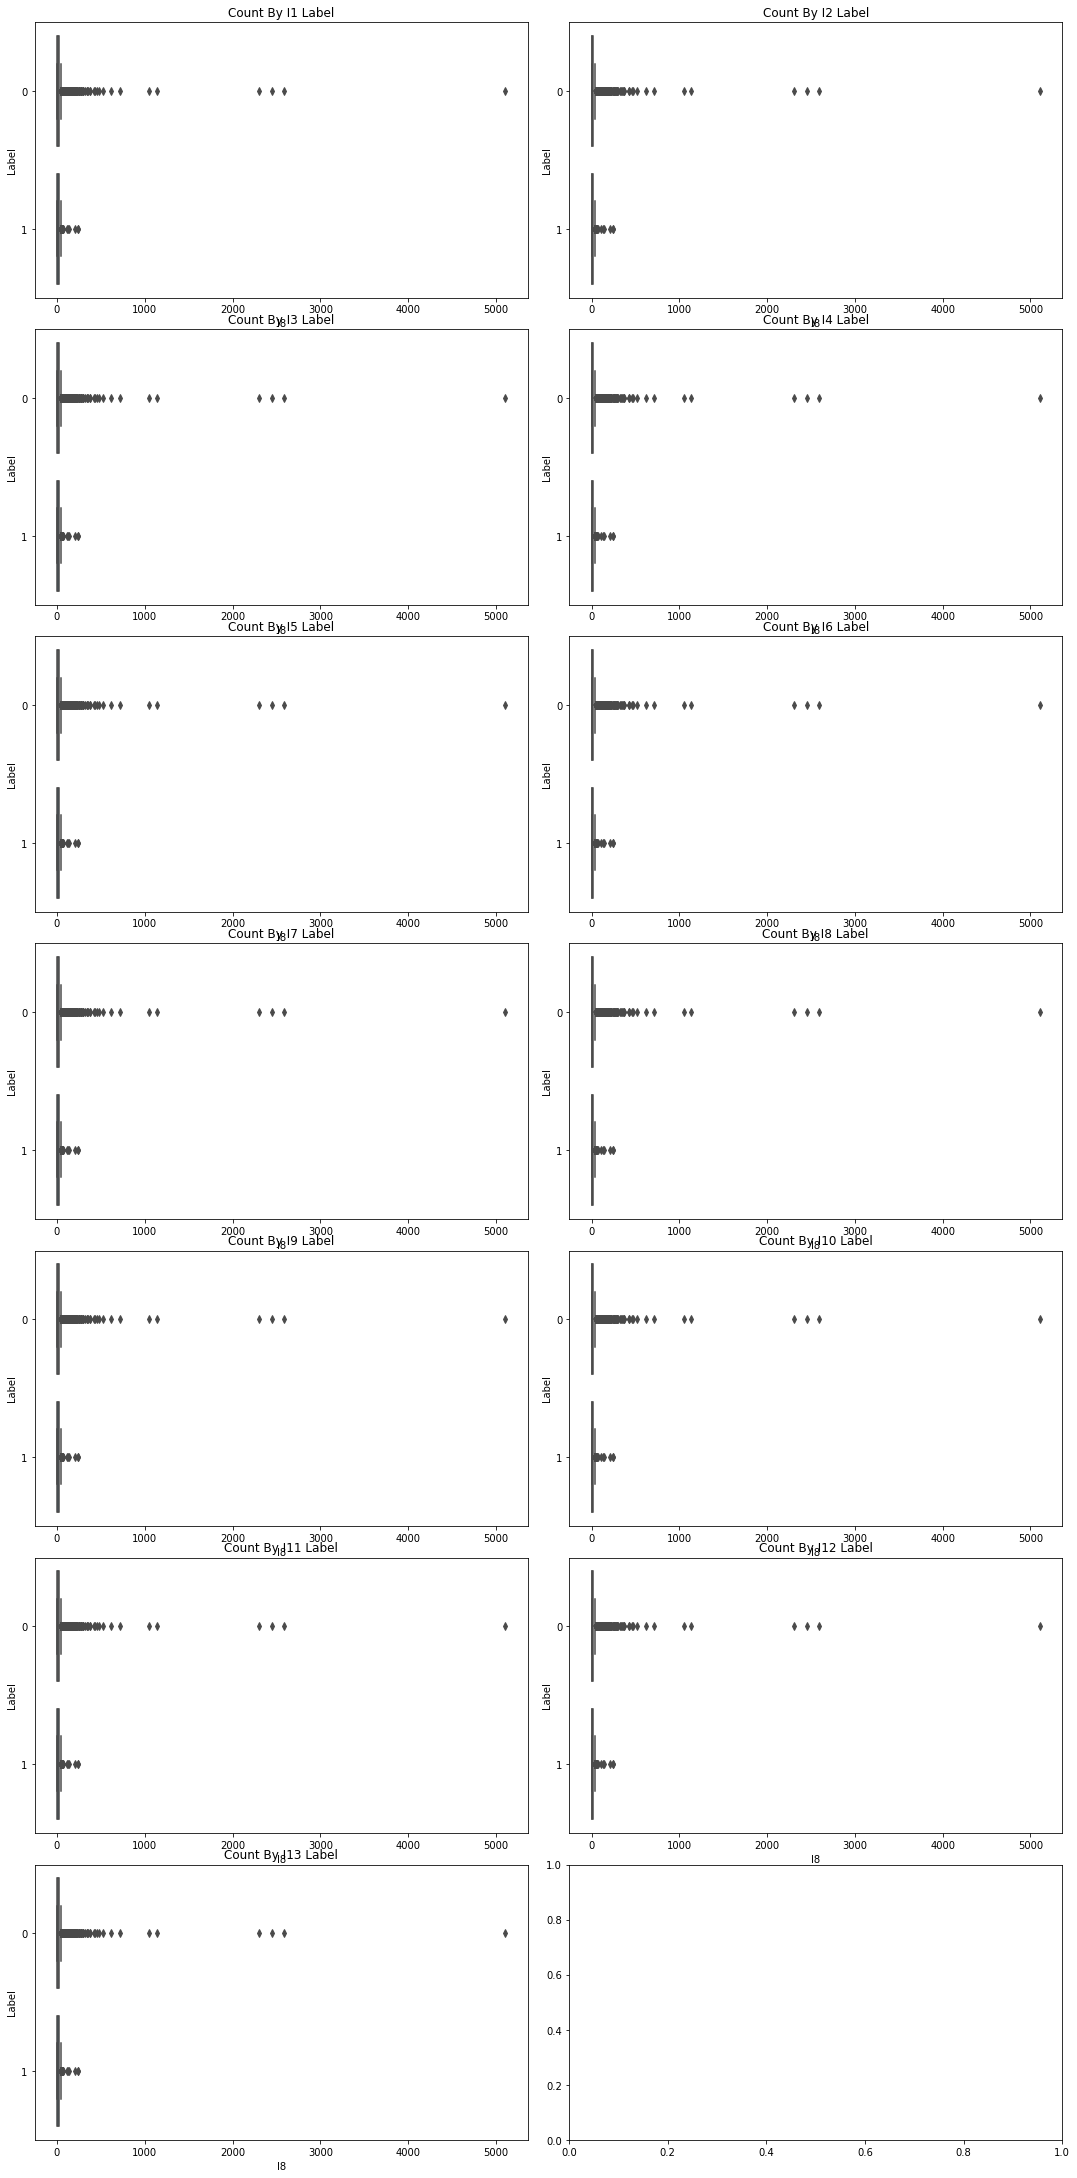

In [51]:
fig, ax = plt.subplots(7, 2,figsize=(15,30))
plt.tight_layout()
fno = 0
# axes are in a two-dimensional array, indexed by [row, col]
for i in range(7):
    for j in range(2):
        fno += 1
        if fno == 14:
            break
        col = "I" + str(fno)
        sns.boxplot(data = sample_df, x='I8',y='Label',ax=ax[i,j],palette="Blues").set_title('Count By I'+str(fno)+' Label')

In [86]:
# Convert the entire train RDD to Dataframe
ctr_df = ctr_train_RDD_cached.toDF(FIELDS).cache()

In [87]:
from pyspark.sql.functions import col, countDistinct
from collections import defaultdict
from collections import namedtuple

# This function gets the top n categories for all categorical columns and stores it in a dictionary

def gettopcategories(df,columns,no_of_top_categories):    
    topcat = defaultdict(list)
    for c in columns:
        top = df.groupby(c).count().orderBy('count', ascending=False).head(no_of_top_categories)

        for i in top:
            topcat[c].append(getattr(i,c))

    return topcat

categoricalColumns = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

no_of_top_categories = 10

topcat = gettopcategories(ctr_df,categoricalColumns,no_of_top_categories)

In [88]:
# Update the train data to have only the top categories and bucketing not so common categories on to a single category "rare".
from pyspark.sql.functions import udf
from pyspark.sql.functions import lit

def topcategories(x,colname):
    if x in topcat[colname]:
        return x
    else:
        return "rare"

topcategories_udf = udf(topcategories)

for col in categoricalColumns:
    ctr_df = ctr_df.withColumn(col,topcategories_udf(col,lit(col)))

In [89]:
# Convert all Blank values to Nulls
from pyspark.sql.functions import *
#ctr_df.where((col("C3")== "" )).count()
#ctr_df.withColumn("C19",when(col("C19") != "", col("C19")).otherwise(None))
#.where((col("C19").isNotNull())).count()
for f in FIELDS:
    ctr_df = ctr_df.withColumn(f,when(col(f) != "", col(f)).otherwise(None))


In [118]:
numericCols = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']

for col_name in numericCols:
    ctr_df = ctr_df.withColumn(col_name, col(col_name).cast('float'))
ctr_df = ctr_df.cache()
ctr_df.dtypes


[('I1', 'float'),
 ('I2', 'float'),
 ('I3', 'float'),
 ('I4', 'float'),
 ('I5', 'float'),
 ('I6', 'float'),
 ('I7', 'float'),
 ('I8', 'float'),
 ('I9', 'float'),
 ('I10', 'float'),
 ('I11', 'float'),
 ('I12', 'float'),
 ('I13', 'float'),
 ('C1', 'string'),
 ('C2', 'string'),
 ('C3', 'string'),
 ('C4', 'string'),
 ('C5', 'string'),
 ('C6', 'string'),
 ('C7', 'string'),
 ('C8', 'string'),
 ('C9', 'string'),
 ('C10', 'string'),
 ('C11', 'string'),
 ('C12', 'string'),
 ('C13', 'string'),
 ('C14', 'string'),
 ('C15', 'string'),
 ('C16', 'string'),
 ('C17', 'string'),
 ('C18', 'string'),
 ('C19', 'string'),
 ('C20', 'string'),
 ('C21', 'string'),
 ('C22', 'string'),
 ('C23', 'string'),
 ('C24', 'string'),
 ('C25', 'string'),
 ('C26', 'string'),
 ('Label', 'string')]

In [119]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
for categoricalCol in categoricalColumns[:5]:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]

In [120]:
label_stringIdx = StringIndexer(inputCol = 'Label', outputCol = 'labelindex')
stages += [label_stringIdx]

In [121]:
from pyspark.ml.feature import Imputer

for n in numericCols:
    
    imputer = Imputer(inputCols=[n], outputCols= [n + "Imputed"]).setStrategy("median")
    stages += [imputer]
    
assemblerInputs = [c + "classVec" for c in categoricalColumns[:5]] + [n + "Imputed" for n in numericCols] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [122]:

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(ctr_df)
newdf = pipelineModel.transform(ctr_df)
selectedCols = ['labelindex', 'features']
newdf = newdf.cache()
newdf.select(selectedCols).show(10,False)


+----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|labelindex|features                                                                                                                                 |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|0.0       |(66,[1,21,22,32,42,53,54,55,57,58,59,60,61,62,63,65],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,2.0])            |
|0.0       |(66,[1,11,22,32,42,53,55,56,57,58,59,60,61,62,63,65],[1.0,1.0,1.0,1.0,1.0,2.0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,1.0,1.0,4.0])               |
|0.0       |(66,[2,11,24,33,42,53,55,56,57,58,59,60,61,62,63,64,65],[1.0,1.0,1.0,1.0,1.0,2.0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,1.0,3.0,3.0,45.0])    |
|0.0       |(66,[1,11,22,32,42,53,54,55,56,57,58,62,65],[1.0,1.0,1.0,1.0,1.0,1.0,893.0,6.0,4.0

In [123]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'labelindex', maxIter=5)
lrModel = lr.fit(newdf)

Text(0, 0.5, 'Beta Coefficients')

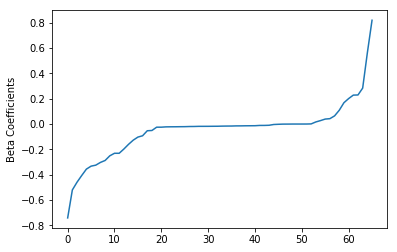

In [125]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

In [39]:
from google.cloud import storage

client = storage.Client()

bucket = client.get_bucket('arvindw261bucket')

blob = bucket.get_blob('ctr_sample_df.pkl')


In [38]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/arganesa/a.json"

In [40]:
blob.download_to_filename("/home/arganesa/bucket.pkl")

In [41]:
sample_df_bucket = pd.read_pickle('/home/arganesa/bucket.pkl')

In [42]:
sample_df_bucket.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,4,403,2,6,1409,21,10,9,74,0,...,195c811d,,,306c202e,,32c7478e,340d03c3,,,1
1,,2,4,5,23024,,0,23,1,,...,1b884e69,,,15dfed46,,423fab69,8e84e831,,,0
2,,13,,1,2996,11,4,1,11,,...,f54016b9,21ddcdc9,a458ea53,ff03efec,78e2e389,32c7478e,0df4da2b,e8b83407,cdf355d3,0
3,,1,10,,31517,125,26,9,58,,...,e88ffc9d,5faa1322,b1252a9d,316279fa,,3a171ecb,5e1d54ab,cb079c2d,b2671abd,0
4,,4,145,10,3830,,0,16,18,,...,ffd53157,21ddcdc9,5840adea,5f6bc5d6,c9d4222a,32c7478e,1793a828,e8b83407,4e7af834,0


In [57]:
spark